In [4]:
import pandas as pd 
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from  nltk.stem import PorterStemmer
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

#import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
twitter_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data.csv", encoding='latin', header=None)

In [6]:
twitter_data = twitter_data[[0, 5]]
twitter_data.rename(columns = {0:'polarity', 5:'text'}, inplace=True)

In [7]:
pd.set_option('max_colwidth', 140)

In [8]:
sentiment = {0:0, 4:1}
def label_decoder(label):
  return sentiment[label]
twitter_data.polarity = twitter_data.polarity.apply(lambda x: label_decoder(x))
twitter_data.head()

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [9]:
stop_words = stopwords.words("english")
stemmer = PorterStemmer()

def text_processing(data):
    '''
    Data processing
    data -- whole dataset to processing
    text_column -- the name of columns in dataset which contains text need to be processed
    '''
    data = data.apply(lambda tweet: tweet.lower()) #loer register
    data = data.apply(lambda tweet: re.sub(r'@\S+', '', tweet)) # usernames
    data = data.apply(lambda tweet: re.sub(r'https?://\S+', '', tweet)) # urls
    data = data.apply(lambda tweet: re.sub(r'#\S+', '', tweet)) #hashtags
    data = data.apply(lambda tweet: re.sub(r'\S+\.com', '', tweet)) # sites 
    #data = data.apply(lambda tweet: re.sub(re_digits, '', tweet))
    data = data.apply(lambda tweet: re.sub(r'[^A-Za-z0-9]', ' ', tweet)) #punctuation
    #data = data.apply(lambda tweet: re.sub(re_preprocessing, '', tweet))
    data = data.apply(lambda tweet: [word for word in tweet.split(' ') if word not in stop_words]) #delete stop_words
    data = data.apply(lambda tweet: [re.compile(r'(.)\1{2,}').sub(r'\1\1', word) for word in tweet]) #delete characters repeted more frequent than 2 times.
    data = data.apply(lambda tweet: [stemmer.stem(word) for word in tweet]) #stemming
    data = data.apply(lambda tweet: [word for word in tweet if word != ''])
    data = data.apply(lambda tweet: ' '.join(tweet))
    return data
    

In [10]:
twitter_data.text = text_processing(twitter_data.text)

LSTM

In [11]:
train_data, test_data = train_test_split(twitter_data, test_size=0.2, stratify = twitter_data.polarity, random_state=42)

In [12]:
train_data.polarity.value_counts()

1    640000
0    640000
Name: polarity, dtype: int64

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 180098


In [14]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)



Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [15]:
labels = train_data.polarity.unique().tolist()

In [16]:
encoder = LabelEncoder()
encoder.fit(train_data.polarity.to_list())

y_train = encoder.transform(train_data.polarity.to_list())
y_test = encoder.transform(test_data.polarity.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-05-18 08:29:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-18 08:29:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-18 08:29:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [18]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [20]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)



In [24]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [25]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)



In [27]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 1251s 997ms/step - loss: 0.5635 - accuracy: 0.7009 - val_loss: 0.5085 - val_accuracy: 0.7473
Epoch 2/10
1250/1250 [==============================] - 1245s 996ms/step - loss: 0.5127 - accuracy: 0.7439 - val_loss: 0.4982 - val_accuracy: 0.7536
Epoch 3/10
1250/1250 [==============================] - 1238s 990ms/step - loss: 0.5005 - accuracy: 0.7523 - val_loss: 0.4955 - val_accuracy: 0.7562
Epoch 4/10
1250/1250 [==============================] - 1239s 991ms/step - loss: 0.4961 - accuracy: 0.7553 - val_loss: 0.4902 - val_accuracy: 0.7582
Epoch 5/10
1250/1250 [==============================] - 1244s 995ms/step - loss: 0.4916 - accuracy: 0.7576 - val_loss: 0.4902 - val_accuracy: 0.7597
Epoch 6/10
1250/1250 [==============================] - 1245s 996ms/step - loss: 0.4873 - accuracy: 0.7610 - val_loss: 0.4889 - val_accuracy: 0.7592
Epoch 7/10
1250/1250 [==============================] - 1239s 991ms/step - loss: 0.4850 - accuracy: 0.7625

In [29]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/best_model.hdf5')

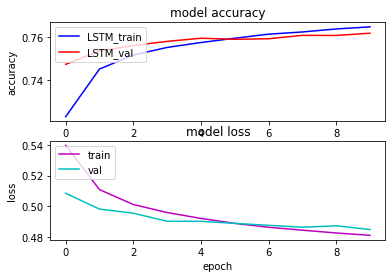

In [31]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

plt.savefig("/content/gdrive/MyDrive/Colab Notebooks/neural_network.png", format='png')

In [32]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 64s 2s/step


In [108]:
metrics_NN = history.history

In [111]:
metrics_NN = pd.DataFrame(metrics_NN)

In [113]:
metrics_NN.index = range(1, 11)

In [120]:
metrics_NN.to_csv('/content/gdrive/MyDrive/Colab Notebooks/neural_network_metrics.csv')